# How to set up your computer to use [Altair](https://altair-viz.github.io/index.html) with Qubole data

## Essential

### Install Python 3
Check if you have python installed by running in your terminal/console:

```
python3 --version
```

If you do not have Python 3 installed and are on a mac then follow [these instructions](https://wsvincent.com/install-python3-mac/) to install Python3 using the homebrew package manager.

### Create a Python 3 virtual environment called 'pydatavis' and activate it

If you have Python 3 you will also have the venv package installed. Follow the helpful [instructions here](https://wsvincent.com/install-python3-mac/) (same steps for macOS and Windows) here to create and activate a virtual environment if you haven't done so before.

### Install Altair, JupyterLab and Pandas in your new pydatavis virtual environment

Run in your terminal/console:

```
pip install -U altair vega_datasets jupyterlab pandas
```

### Install the Qubole Data Service Python SDK in your pydatavis virtual environment

As described in the [module documentation](https://github.com/qubole/qds-sdk-py) install by running in your terminal/console:

```bash
pip install qds-sdk
```

### Check that you can pull data from an HCOM Qubole Account

Create a connector class in this Jupyter notebook by running the following cell (Shift+Enter):

In [5]:
import os
import re
import pandas as pd
from qds_sdk.commands import HiveCommand
from qds_sdk.qubole import Qubole

class QuboleConnector():
    def __init__(self, hcom_api_token, bex_api_token):
        pass

    def query_data(self, sql_query, account):
        if account == 'hcom':
            Qubole.configure(api_token=hcom_api_token)
        else:
            Qubole.configure(api_token=bex_api_token)
                
        cmd = self.execute_query(sql_query)

        if HiveCommand.is_success(cmd.status):
            with open("temp_data.csv", 'w') as writer:
                if account == 'hcom':
                    cmd.get_results(writer, delim=",", inline=False)
                else:
                    cmd.get_results(writer, delim="\t", inline=False)

            clean_query = sql_query.replace('\n', '')
            clean_query = re.sub("\\([^)]*?\\)", "", clean_query)
            heads = re.search('select(.*?)from', clean_query.lower()).group(1).split(',')
            heads = [h.strip() for h in heads]
            heads = [h if ' as ' not in h else re.search(' as (.*)', h).group(1) for h in heads]      
        
        if account == 'hcom':
            query_result = pd.read_csv("temp_data.csv", names = heads)
        else:
            query_result = pd.read_csv("temp_data.csv", names = heads, sep='\t')
        os.remove("temp_data.csv")
        return query_result

    def execute_query(self, sql_query):
        hc_params = ['--query', sql_query]
        hive_args = HiveCommand.parse(hc_params)
        cmd = HiveCommand.run(**hive_args)
        return cmd

Set your Qubole API token(s) which can be found [here](https://api.qubole.com/v2/control-panel#manage-accounts) in the next cell.

In [6]:
hcom_api_token='e430f9db5ff2473897c52d834f4a65742cdddcadbb43409e8684b7309d26e194'

Instatiate a Qubole connector object with the token(s):

In [7]:
con = QuboleConnector(hcom_api_token, bex_api_token)

Query a table in Qubole and assign the result to a pandas dataframe in local memory:

In [24]:
hcom_data_sample_query = """
SELECT 
    booking_gross_profit_amt_usd
    ,omniture_gross_booking_value_usd
    ,omniture_user_context_pos
FROM bix_clickstream.hermes_omniture_booking_order_summary
WHERE omniture_local_date > DATE_SUB(CURRENT_DATE, 7)
AND omniture_local_hour = 20
AND SUBSTR(omniture_user_context_pos, 6,2) IN ('UK','DE','ES','FR','IT')

LIMIT 100
"""

hcom_data_sample_df = con.query_data(sql_query=hcom_data_sample_query, account='hcom') 

If the following cell returns as output a table with 5 rows of data then you're now set up to pull HCOM data from Qubole into a Jupyter notebook.

In [23]:
hcom_data_sample_df.head()

,booking_gross_profit_amt_usd,omniture_gross_booking_value_usd,omniture_user_context_pos
0,11.6355,66.1200,HCOM_US
1,26.6831,321.9600,HCOM_US
2,18.9143,181.9237,HCOM_DK
3,12.9442,78.2200,HCOM_US
4,55.4240,957.0914,HCOM_FR


### Check that you can render the data with Altair

Run the following cell. If it returns an *interactive* scatter plot then you're now ready to create powerful data visualisations with [Altair](https://altair-viz.github.io/index.html) in a Jupyter notebook.

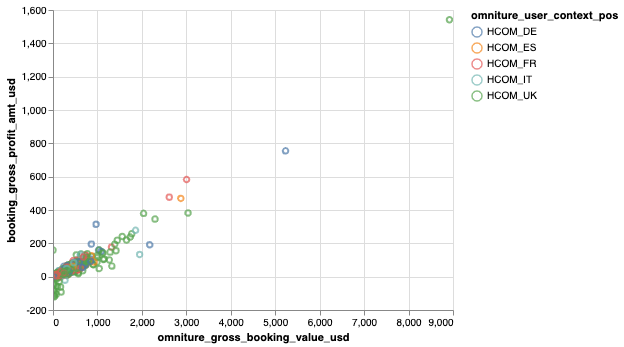

In [37]:
import altair as alt

alt.Chart(hcom_data_sample_df).mark_point().encode(
    x = 'omniture_gross_booking_value_usd',
    y = 'booking_gross_profit_amt_usd',
    color = 'omniture_user_context_pos'
).interactive()

## Optional

### Check if you can pull data from a BEX Qubole Account

Set your BEX API token, which can be found [here](https://api.qubole.com/v2/control-panel#manage-accounts).

In [3]:
bex_api_token='4ddc9f9d5bfd452ab0aaca49625af6082d6f016e57c04cbe8abd64002ed346af'

Launch a test query on a table in the BEX Qubole account:

In [11]:
bex_data_sample_query = """
SELECT 
    expe_property_id
    ,hcom_property_id
    ,super_region_name
FROM dm.property
WHERE hcom_property_id IS NOT NULL

LIMIT 100
"""

# below we pass 'bex' argument to account parameter of query_data function
bex_data_sample_df = con.query_data(sql_query=bex_data_sample_query, account='bex') 

If the following cell returns as output a table with 5 rows of data then you're now set up to pull BEX data from Qubole into a Jupyter notebook.

In [12]:
bex_data_sample_df.head()

,expe_property_id,hcom_property_id,super_region_name
0,21667,207260,AMER
1,21667119,694347808,AMER
2,2166715,272453,EMEA
3,21667329,694354528,AMER
4,21667699,694366368,AMER
